In [6]:
%pylab inline
import comptox_ai
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [2]:
cai = comptox_ai.ComptoxAI(config_file = '../CONFIG-default.cfg')

Loading configuration file...
bolt://localhost:7687


- - -
## Degree distribution

#### All named individuals

In [3]:
deg = cai.graph.get_node_degrees()

In [4]:
len(deg)

36489

In [5]:
_, d = zip(*deg)

In [6]:
d_mod = [x for x in d if (x <= 200)]
num_pruned = sum([1 for x in d if x > 200])

(0, 225)

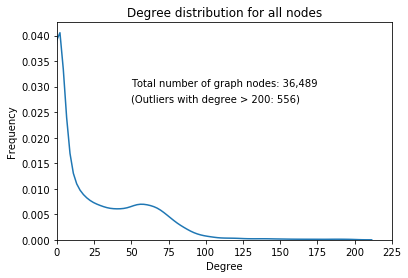

In [7]:
ax = sns.distplot(d_mod, hist=False)
plt.xlabel('Degree')
plt.ylabel('Frequency')

#ax.legend('Total number of graph nodes: {}'.format(len(d)))
ax.text(50,0.030,'Total number of graph nodes: {:,}'.format(len(d)))
ax.text(50,0.027,'(Outliers with degree > 200: {:,})'.format(num_pruned))

ax.set_title("Degree distribution for all nodes")

plt.xlim((0,225))

#### Degree distribution by class membership

In [8]:
populated_classes = cai.graph.fetch_ontology_class_labels()
print(populated_classes)

node_degrees_by_class = {}
for k, v in populated_classes.items():
    if v > 100:
        this_node_degrees = cai.graph.get_node_degrees(k)
        _, d = zip(*this_node_degrees)
        node_degrees_by_class[k] = d

{'MolecularInitiatingEvent': 172, 'AOP': 322, 'KeyEvent': 724, 'AdverseOutcome': 134, 'Disease': 6059, 'Gene': 20943, 'Phenotype': 438, 'Chemical': 1552, 'AdverseEffect': 5734, 'StructuralEntity': 402, 'Database': 9}


In [9]:
# number of standard deviations for pruning outliers
m = 3

def make_degree_plot(class_label, axx, use_log_y=False):
    deg_list = np.array(node_degrees_by_class[class_label])
    
    
    no_outliers = deg_list[abs(deg_list - np.mean(deg_list)) < m * np.std(deg_list)]
    num_outliers = len(deg_list) - len(no_outliers)
    
    dp = sns.distplot(no_outliers,
                      hist=False,
                      ax=axx)
    
    ax = dp.axes
    ax.set_title(f"Degree distribution for '{class_label}'")
    ax.set_xlim((0,max(no_outliers)))
    
    text_x_start = float(max(no_outliers))/2.
    text_y_start = ax.get_ylim()[-1]*.8
    
    axx.text(text_x_start,text_y_start*1.1,'Total number of graph nodes: {:,}'.format(len(deg_list)))
    axx.text(text_x_start,text_y_start,'(Outliers with degree > {}: {:,})'.format(max(no_outliers),num_outliers))

    if use_log_y:
        plt.yscale('log')

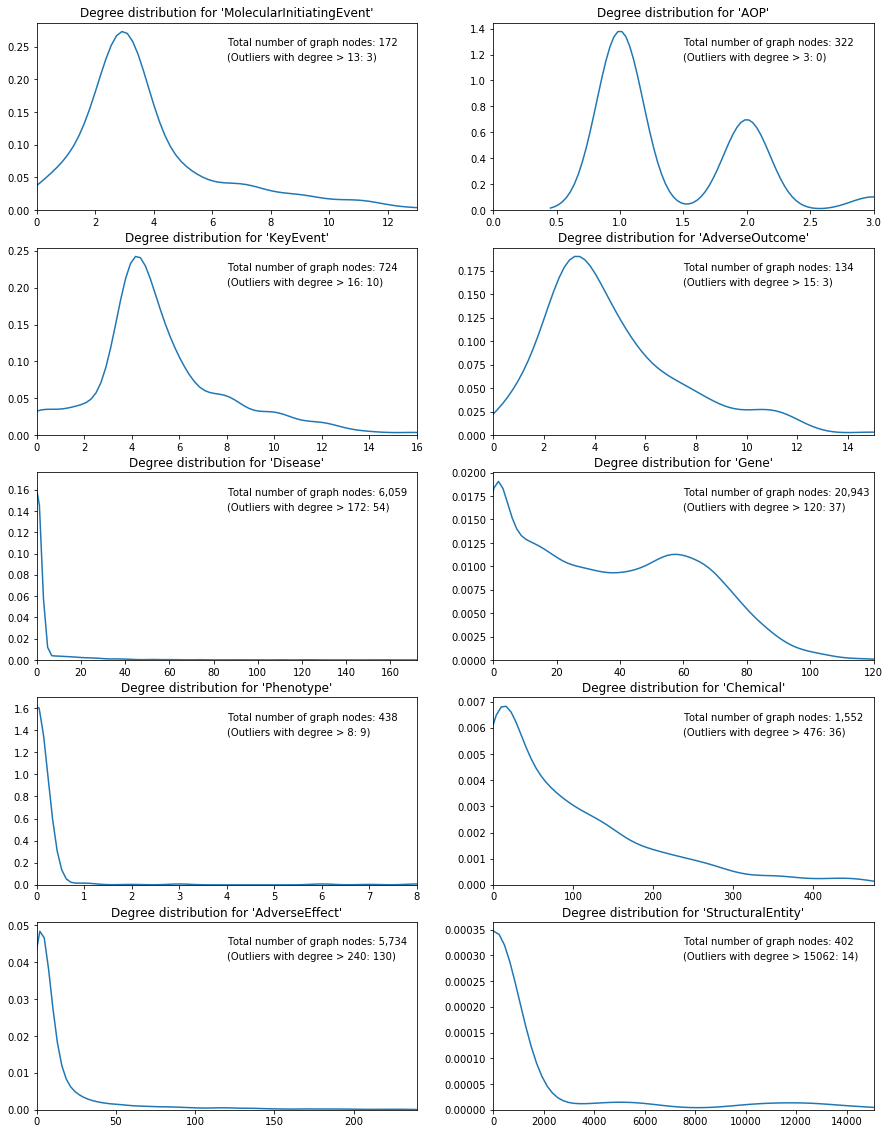

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=2)

node_deg_list = [(k, v) for k, v in node_degrees_by_class.items()]

for i, a in enumerate(axs.flat):
    cls_lab, degs = node_deg_list[i]
    
    make_degree_plot(cls_lab, a)
    
fig.set_figheight(20)
fig.set_figwidth(15)

- - -
## Page rank on graph nodes

In [3]:
pr = cai.graph.page_rank()

In [22]:
pagerank = defaultdict(list)
for x, y in pr:
    node_name = x.split("#")[-1]
    pr_value = y
    
    prefix = node_name.split("_")[0]
    suffix = node_name[len(prefix)+1:]
    if prefix.lower() == prefix:
        pagerank[prefix].append((suffix, pr_value))
        
# Note: results are already in sorted order!

In [23]:
pagerank.keys()

dict_keys(['se', 'chem', 'ae', 'dis', 'gene', 'ke', 'ao', 'mie', 'aop', 'phen'])

In [26]:
def top_pr_values(class_prefix, num_top_ranks=15):
    x, y = zip(*pagerank[class_prefix])
    return x[:num_top_ranks]

In [27]:
top_pr_values('dis')

('breast_cancer',
 'schizophrenia',
 'hematologic_cancer',
 'polycystic_ovary_syndrome',
 'melanoma',
 'rheumatoid_arthritis',
 'iga_glomerulonephritis',
 'hypertension',
 'azoospermia',
 'abdominal_aortic_aneurysm',
 "alzheimer's_disease",
 'lung_cancer',
 "parkinson's_disease",
 'chronic_obstructive_pulmonary_disease',
 'amyotrophic_lateral_sclerosis')

In [28]:
top_pr_values('gene')

('cyp3a4',
 'cyp2d6',
 'abcb1',
 'cyp2c9',
 'cyp1a2',
 'cyp2c19',
 'alb',
 'hrh1',
 'cyp3a5',
 'cyp2c8',
 'ptgs2',
 'cyp2e1',
 'htr2a',
 'ptgs1',
 'cyp2b6')

In [29]:
top_pr_values('phen')

('ataxia_telangiectasia',
 'supranuclear_palsy,_progressive',
 'cough',
 'coffin-lowry_syndrome',
 'spinocerebellar_ataxias',
 'menkes_kinky_hair_syndrome',
 'orthostatic_intolerance',
 'pyruvate_dehydrogenase_complex_deficiency_disease',
 'mevalonate_kinase_deficiency',
 'sneezing',
 'dyspnea',
 'cyanosis',
 'wolfram_syndrome',
 'apraxias',
 'adrenoleukodystrophy')